In [20]:
%matplotlib inline
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")
from tqdm import tqdm

import config
from graph_models import FullGraphModel
from complete_training_data_processing import CompleteModelsDataProcessor
from model_inspection_funcs import neuron_data_from_image, propagate_neuron_data, sample_images

device = torch.device("cpu")
dtype = torch.float32

In [21]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=config.DEVICE,
    num_classes=len(config.CLASSES),
).to(device)

In [22]:
# horrible data stuff
checkpoint = torch.load("models/model_2024-05-20 03:41:43.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.eval()
connections = (
    pd.read_csv(
        "adult_data/connections.csv",
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    .groupby(["pre_root_id", "post_root_id"])
    .sum("syn_count")
    .reset_index()
)

connections["weight"] = model.connectome.edge_weight_multiplier.detach()
right_root_ids = data_processor.right_root_ids
all_neurons = (
    pd.read_csv("adult_data/classification_clean.csv")
    .merge(right_root_ids, on="root_id")
    .fillna("Unknown")
)
neuron_data = pd.read_csv(
    "adult_data/right_visual_positions_selected_neurons.csv",
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])
data_cols = ["x_axis", "y_axis"]
all_coords = pd.read_csv("adult_data/all_coords_clean.csv", dtype={"root_id": "string"})
rational_cell_types = pd.read_csv("adult_data/rational_cell_types.csv")
all_neurons["decision_making"] = np.where(
    all_neurons["cell_type"].isin(rational_cell_types["cell_type"].values.tolist()),
    1,
    0,
)
all_neurons["root_id"] = all_neurons["root_id"].astype("string")

In [23]:
num_passes = 4
base_dir = "images/five_to_fifteen/train"
sub_dirs = ["yellow", "blue"]

sampled_images = sample_images(base_dir, sub_dirs, 100)

dms = {}
for img in tqdm(sampled_images):
    activated_data = neuron_data_from_image(sampled_images[1], neuron_data)
    propagation = propagate_neuron_data(
        activated_data, connections, all_coords, all_neurons, num_passes
    )
    dms[os.path.basename(img)] = propagation["decision_making"][all_neurons["decision_making"] == 1]


 50%|█████     | 100/200 [04:48<04:48,  2.89s/it]/tmp/ipykernel_111384/2208910999.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dms[os.path.basename(img)] = propagation["decision_making"][all_neurons["decision_making"] == 1]
 50%|█████     | 101/200 [04:51<04:46,  2.89s/it]/tmp/ipykernel_111384/2208910999.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dms[os.path.basename(img)] = propagation["decision_making"][all_neurons["decision_making"] == 1]
 51%|█████     | 102/200 [04:54<04:46,  2.93s/it]/tmp/ipykernel_111384

In [39]:
means = pd.DataFrame(dms.mean(axis=0))
means = means.rename(columns={0: "mean"})
means["yellow"] = [int(a.split("_")[1]) for a in means.index]
means["blue"] = [int(a.split("_")[2]) for a in means.index]
means["color"] = means[["yellow", "blue"]].idxmax(axis=1)

<Axes: xlabel='color', ylabel='mean'>

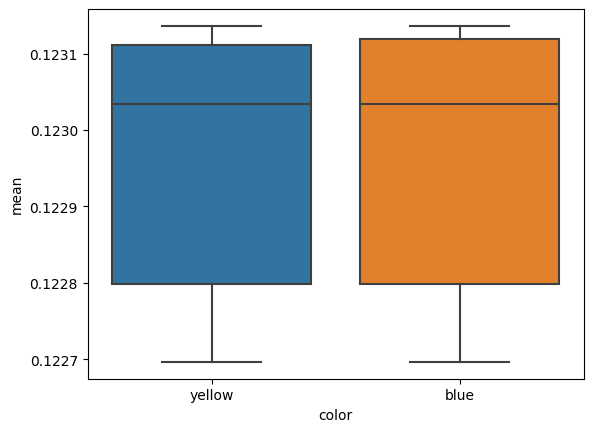

In [42]:
# boxplot of mean depending on color using seaborn
import seaborn as sns

sns.boxplot(x="color", y="mean", data=means)

In [13]:
sampled_images[0]

'images/five_to_fifteen/train/yellow/img_9_6_58_equalized_.png'

In [43]:
model.final_fc.weight

Parameter containing:
tensor([[-8.3752],
        [ 7.2369]], requires_grad=True)

In [44]:
model.final_fc.bias

Parameter containing:
tensor([-0.3962, -0.3513], requires_grad=True)